In [1]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
import missingno as msno
import fancyimpute as fi
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='poster', style='ticks')
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel,  wilcoxon, mannwhitneyu, ttest_ind_from_stats
import statsmodels as sm


#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn.mass_univariate import permuted_ols

Using TensorFlow backend.


In [2]:
def calculate_pvalues(df, correlation):
    from scipy.stats import pearsonr, pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if correlation == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            if correlation == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            else:
                raise ValueError('Invalid correlation method specified. Accpetable values are \'pearson\' and \'spearman\'.')
    return pvalues

In [3]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def liji_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
#reading in and rearranging data
data_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/data'
fig_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/figures'

demo_df = pd.read_csv(join(data_dir, 'c123456_FullDemographics.csv'), encoding='iso-8859-1', 
                      index_col=0, header=0, skipfooter=1, engine='python')
iq_df = pd.read_csv(join(data_dir, 'wais-iv_rescored.csv'), index_col=0, header=0)

gidf_df = pd.read_csv(join(data_dir, 'rescored_gender_identity_female.csv'), 
                     skiprows=1, usecols=['Physics_ID', 'GID Pre', 'GID Post'], index_col=0)
gidm_df = pd.read_csv(join(data_dir, 'rescored_gender_identity_male.csv'), 
                     skiprows=1, usecols=['Physics_ID', 'GID Pre', 'GID Post'], index_col=0)

In [5]:
gid_df = pd.concat([gidf_df, gidm_df], axis=0)


In [6]:
demo_df[demo_df['Strt.Level'] < 0] = np.nan


In [7]:
post_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_post.txt'), sep='\t', index_col=1)
post_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'RetrPhyAcc2'}, axis='columns', inplace=True)
post_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Post',
                      'Mean Incorrect RT': 'Mean Incorrect RT Post'}, axis=1, inplace=True)

pre_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_pre.txt'), sep='\t', index_col=1)
pre_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'RetrPhyAcc1'},axis='columns', inplace=True)
pre_phy_rt_df.drop('Class', axis=1, inplace=True)
pre_phy_rt_df.drop('Gender', axis=1, inplace=True)
pre_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Pre',
                      'Mean Incorrect RT': 'Mean Incorrect RT Pre'}, axis=1, inplace=True)

phy_rt_df = pd.concat((pre_phy_rt_df, post_phy_rt_df), axis=1)
#phy_rt_df.rename({'Mean Correct RT': 'Mean Correct Physics RT',
#                  'Mean Incorrect RT': 'Mean Incorrect Physics RT'}, axis=1, inplace=True)

In [8]:
fci_bx_df = pd.read_csv(join(data_dir, 'fci_accuracy_rt.txt'), sep='\t', index_col=[0,1], header=0)
fci_bx_pre = pd.Series(fci_bx_df.xs('session-0', level='Session')['Mean FCI Accuracy'], name='FCIPhyAcc1')
fci_bx_post = pd.Series(fci_bx_df.xs('session-1', level='Session')['Mean FCI Accuracy'], name='FCIPhyAcc2')

In [9]:
#iq = pd.read_excel('/Users/katherine/Dropbox/Physics Learning/Physics learning_Full Scale IQ.xlsx', index_col=0, header=0)
pre_iq = ['VCI1', 'PRI1', 'WMI1', 'PSI1', 'FSIQ1']
post_iq = ['VCI2', 'PRI2', 'WMI2', 'PSI2', 'FSIQ2']
iq_vars = pre_iq + post_iq
iqs = ['VCI', 'PRI', 'WMI', 'PSI', 'FSIQ']
drop = set(iq_df.keys()) - set(iq_vars)
iq_df.drop(drop, axis=1, inplace=True)

In [10]:
subjects = iq_df.index.values

In [11]:
all_df = pd.concat([demo_df, phy_rt_df, fci_bx_pre, fci_bx_post, iq_df, gid_df], axis=1)
#all_df = pd.concat([all_df, ], axis=1)
all_df.replace({'Lect': 'Lec'}, inplace=True)

In [12]:
all_df['deltaRetrPhyAcc'] = all_df['RetrPhyAcc2'] - all_df['RetrPhyAcc1']
all_df['deltaFCIPhyAcc'] = all_df['FCIPhyAcc2'] - all_df['FCIPhyAcc1']
all_df['deltaVCI'] = all_df['VCI2'] - all_df['VCI1']
all_df['deltaPRI'] = all_df['PRI2'] - all_df['PRI1']
all_df['deltaWMI'] = all_df['WMI2'] - all_df['WMI1']
all_df['deltaPSI'] = all_df['PSI2'] - all_df['PSI1']
all_df['deltaFSIQ'] = all_df['FSIQ2'] - all_df['FSIQ1']

In [13]:
all_df.drop(['Section', 'Score', 'Test.ID', 'Component',
             'Acad.Plan', 'Study.Cmplt', 'Mean Incorrect RT Pre', 'Mean Incorrect RT Post',
             'Gender', 'Class', 'index', 'Gender And Class', 'Session'], axis=1, inplace=True)

In [14]:
all_df.keys()

Index(['Class.Type', 'Sex', 'Ethnic.Grp', 'GPA', 'Age', 'Handedness',
       'Strt.Level', 'RetrPhyAcc1', 'Mean Correct RT Pre', 'RetrPhyAcc2',
       'Mean Correct RT Post', 'FCIPhyAcc1', 'FCIPhyAcc2', 'VCI1', 'PRI1',
       'WMI1', 'PSI1', 'FSIQ1', 'VCI2', 'PRI2', 'WMI2', 'PSI2', 'FSIQ2',
       'GID Pre', 'GID Post', 'deltaRetrPhyAcc', 'deltaFCIPhyAcc', 'deltaVCI',
       'deltaPRI', 'deltaWMI', 'deltaPSI', 'deltaFSIQ'],
      dtype='object')

In [15]:
grade = pd.read_csv(join(data_dir, 'iq+brain+demo.csv'), usecols=['ID', 'Phy48Grade'], index_col=0)

In [16]:
femm = pd.read_csv(join(data_dir, 'rescored_gender_identity_female.csv'), header=1, 
                   usecols=['Physics_ID', 'GID Pre', 'GID Post'], index_col=0, skiprows=0)
masc = pd.read_csv(join(data_dir, 'rescored_gender_identity_male.csv'), header=1, 
                   usecols=['Physics_ID', 'GID Pre', 'GID Post'], index_col=0, skiprows=0)
femm.head()

,GID Pre,GID Post
Physics_ID,,
101,4.111111,4.111111
104,4.277778,4.352941
107,3.578947,3.631579
108,2.411765,2.500000
211,3.111111,NaN


In [17]:
all_df = pd.concat([all_df, grade], axis=1)

In [18]:
ttest_ind(all_df[all_df['Class.Type']=='Lec']['Age'], all_df[all_df['Class.Type']=='Mod']['Age'])

Ttest_indResult(statistic=0.7165386144366176, pvalue=0.4749641754875975)

In [19]:
df_f = all_df[all_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = all_df[all_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

df_f['const'] = 1
df_m['const'] = 1

In [20]:
print(np.mean(df_f['Age']))
print(np.mean(df_m['Age']))
print(ttest_ind(df_f['Age'], df_m['Age']))

19.910711904590162
20.14480846115942
Ttest_indResult(statistic=-0.5908560138093188, pvalue=0.555658771842628)


# Assessing the shape of the data
Can we use parametric tests? Do we have to switch to nonparametric?

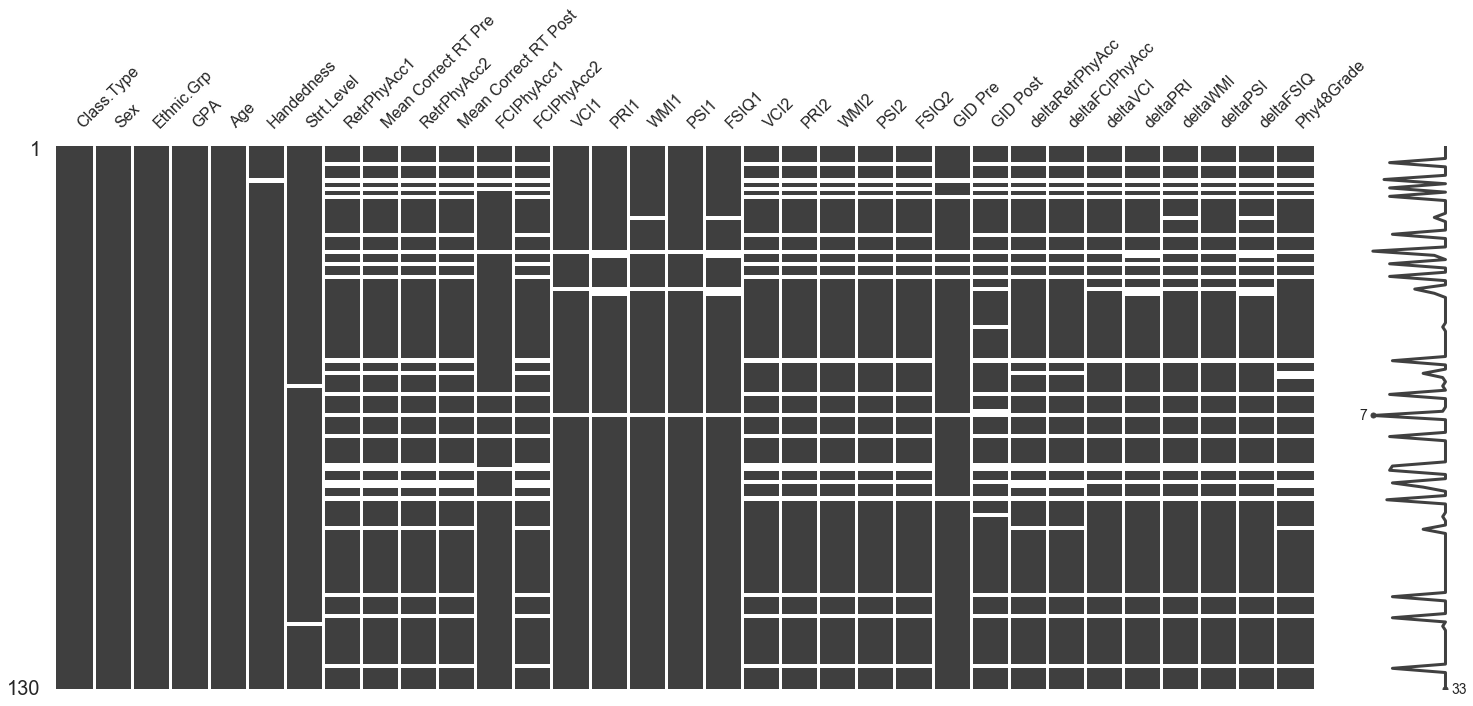

In [21]:
msno.matrix(all_df)

In [22]:
for key in all_df.keys():
    print(key, np.round(1- (all_df[key].dropna().shape[0]/130), 3))

Class.Type 0.0
Sex 0.0
Ethnic.Grp 0.0
GPA 0.0
Age 0.0
Handedness 0.008
Strt.Level 0.015
RetrPhyAcc1 0.169
Mean Correct RT Pre 0.169
RetrPhyAcc2 0.169
Mean Correct RT Post 0.169
FCIPhyAcc1 0.069
FCIPhyAcc2 0.169
VCI1 0.023
PRI1 0.038
WMI1 0.031
PSI1 0.023
FSIQ1 0.046
VCI2 0.146
PRI2 0.146
WMI2 0.146
PSI2 0.146
FSIQ2 0.146
GID Pre 0.054
GID Post 0.177
deltaRetrPhyAcc 0.169
deltaFCIPhyAcc 0.169
deltaVCI 0.154
deltaPRI 0.169
deltaWMI 0.162
deltaPSI 0.154
deltaFSIQ 0.177
Phy48Grade 0.177


In [23]:
missing_df = pd.DataFrame(columns=all_df.keys(), index=all_df.index)

for key in missing_df.keys():
    missing_df[key] = all_df[key].isnull()

missing_df.replace({False: 0, True:1}, inplace=True)

for key1 in missing_df.keys():
    try:
        corr,pval = pearsonr(missing_df[key1], all_df[key1])
        if pval < 0.05:
            print(key1, corr, pval)
    except:
        pass
    for key2 in all_df.keys():
        try:
            corr,pval = pearsonr(missing_df[key1], all_df[key2])
            if pval < 0.05:
                print(key1, key2, corr, pval)
        except Exception as e:
            pass

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Strt.Level Age -0.5788577495018394 5.443947292273022e-13


In [24]:
impute_pls = fi.KNN(k=4, verbose=False)

all_imputed = impute_pls.fit_transform(all_df.drop(['Class.Type', 'Sex', 'Ethnic.Grp'], axis=1))

In [25]:
imputed_df = pd.DataFrame(all_imputed, 
                          columns=all_df.drop(['Class.Type', 'Sex', 'Ethnic.Grp'], axis=1).columns, 
                          index=all_df.index)

In [26]:
imputed_df['Sex'] = all_df['Sex']
imputed_df['Ethnic.Grp'] = all_df['Ethnic.Grp']
imputed_df['Class.Type'] = all_df['Class.Type']

In [27]:
imputed_df.min()

GPA                            0
Age                            0
Handedness                   0.1
Strt.Level                    10
RetrPhyAcc1             0.291667
Mean Correct RT Pre      3170.53
RetrPhyAcc2                0.375
Mean Correct RT Post     3098.46
FCIPhyAcc1                     0
FCIPhyAcc2              0.111111
VCI1                          76
PRI1                          81
WMI1                          77
PSI1                          74
FSIQ1                         80
VCI2                          80
PRI2                          75
WMI2                          69
PSI2                          71
FSIQ2                         83
GID Pre                  2.41176
GID Post                   2.375
deltaRetrPhyAcc            -0.25
deltaFCIPhyAcc         -0.555556
deltaVCI                     -32
deltaPRI                     -21
deltaWMI                     -31
deltaPSI                     -25
deltaFSIQ                    -14
Phy48Grade                     0
Sex       

In [28]:
all_df = imputed_df

In [29]:
all_df.to_csv(join(data_dir, 'rescored', 'physics_learning-nonbrain.csv'))

In [30]:
kurtosis = all_df.kurtosis(axis=0, skipna=True)
mean = all_df.mean(axis=0, skipna=True)
skew = all_df.skew(axis=0, skipna=True)
median = all_df.median(axis=0, skipna=True)
stdev = all_df.std(axis=0, skipna=True)
descriptives = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives.rename(columns={0: 'Mean', 1: 'StDev', 2: 'Median', 3: 'Skew', 4: 'Kurtosis'}, inplace=True)
descriptives.to_csv('{0}/rescored/descriptives_imp.csv'.format(data_dir), sep=',')
descriptives

,Mean,StDev,Median,Skew,Kurtosis
GPA,2.970077,1.043979,3.230000,-1.822938,2.983929
Age,20.034963,2.248706,19.941096,-5.152914,49.079155
Handedness,0.859883,0.166845,0.900000,-1.365312,2.434485
Strt.Level,24.871504,7.980315,20.000000,0.181807,-0.396958
RetrPhyAcc1,0.670775,0.120418,0.682994,-0.417680,0.156242
Mean Correct RT Pre,4343.405845,396.147784,4375.133333,-0.350560,0.288833
RetrPhyAcc2,0.758246,0.114520,0.750000,-0.514802,0.840666
Mean Correct RT Post,4206.575907,410.541589,4223.577894,-0.177243,0.476602
FCIPhyAcc1,0.445416,0.215680,0.444444,0.359255,-0.231283
FCIPhyAcc2,0.616633,0.188165,0.627060,-0.354574,-0.207907


In [31]:
kurtosis = df_f.kurtosis(axis=0, skipna=True)
mean = df_f.mean(axis=0, skipna=True)
skew = df_f.skew(axis=0, skipna=True)
median = df_f.median(axis=0, skipna=True)
stdev = df_f.std(axis=0, skipna=True)
descriptives_f = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives_f.rename(columns={0: 'Mean', 1: 'StDev', 2: 'Median', 3: 'Skew', 4: 'Kurtosis'}, inplace=True)
descriptives_f.to_csv('{0}/rescored/descriptives_f_imp.csv'.format(data_dir), sep=',')

kurtosis = df_m.kurtosis(axis=0, skipna=True)
mean = df_m.mean(axis=0, skipna=True)
skew = df_m.skew(axis=0, skipna=True)
median = df_m.median(axis=0, skipna=True)
stdev = df_m.std(axis=0, skipna=True)
descriptives_m = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives_m.rename(columns={0: 'Mean', 1: 'StDev', 2: 'Median', 3: 'Skew', 4: 'Kurtosis'}, inplace=True)
descriptives_m.to_csv('{0}/rescored/descriptives_m_imp.csv'.format(data_dir), sep=',')

In [32]:
descriptives_m

,Mean,StDev,Median,Skew,Kurtosis
GPA,2.924493,1.097349,3.210000,-1.828278,2.718503
Age,20.144808,1.411054,19.879452,1.630937,3.486734
Handedness,0.827941,0.182720,0.800000,-1.260346,2.376899
Strt.Level,23.382353,7.843677,20.000000,0.463398,-0.027950
RetrPhyAcc1,0.717361,0.093984,0.708333,-0.132506,-0.754076
Mean Correct RT Pre,4283.139574,410.027791,4244.674089,-0.269697,-0.181470
RetrPhyAcc2,0.803472,0.114326,0.833333,-1.030377,2.284620
Mean Correct RT Post,4105.983774,426.620729,4172.798309,-0.342650,0.176236
FCIPhyAcc1,0.548822,0.197687,0.555556,-0.041058,-0.183540
FCIPhyAcc2,0.683333,0.175772,0.777778,-0.813354,0.182577


In [33]:
descriptives_f

,Mean,StDev,Median,Skew,Kurtosis
GPA,3.021639,0.986633,3.230000,-1.825973,3.589479
Age,19.910712,2.930143,20.005479,-5.203871,36.475151
Handedness,0.895082,0.141923,1.000000,-1.321100,1.057922
Strt.Level,26.500000,7.988339,30.000000,-0.099575,-0.376852
RetrPhyAcc1,0.615451,0.144399,0.625000,0.076628,-0.401106
Mean Correct RT Pre,4372.112357,432.315249,4427.757212,-0.251900,0.379821
RetrPhyAcc2,0.717014,0.113365,0.708333,-0.566478,0.643660
Mean Correct RT Post,4321.633837,431.224666,4331.781250,0.000626,-0.144100
FCIPhyAcc1,0.345454,0.190867,0.333333,0.848389,1.767041
FCIPhyAcc2,0.523148,0.197114,0.555556,0.320580,0.435828


In [34]:
short_iqs = ['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ']

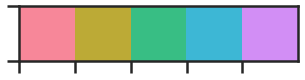

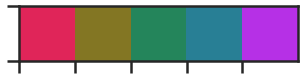

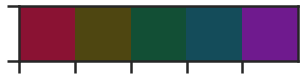

In [35]:
light_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.7)
dark_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.5)
darker_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.3)
sns.palplot(light_hsl)
sns.palplot(dark_hsl)
sns.palplot(darker_hsl)

In [36]:
print(iqs)

['VCI', 'PRI', 'WMI', 'PSI', 'FSIQ']


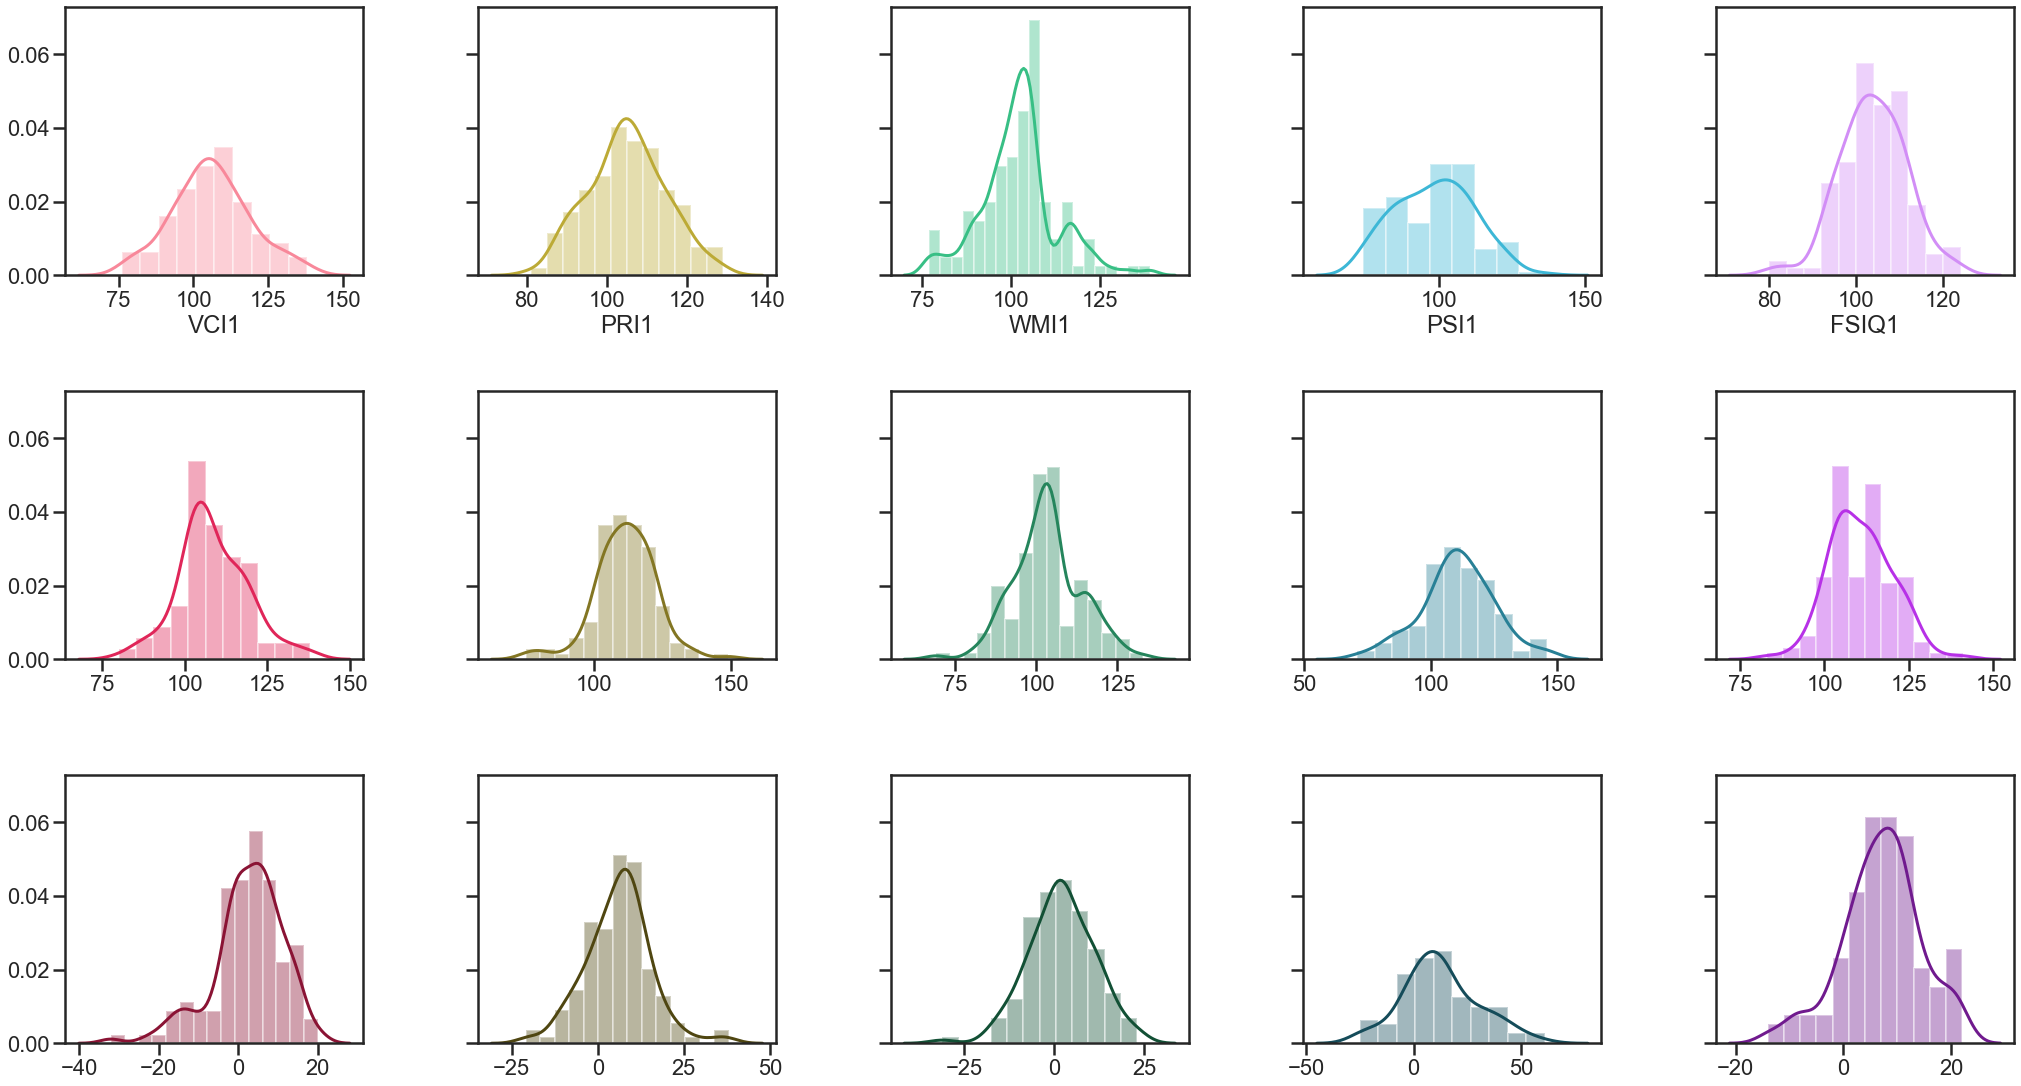

In [37]:
fig,ax = plt.subplots(nrows=3, ncols=5, sharey=True, figsize=(30, 17))
plt.tight_layout(pad=3)

for i in np.arange(0,len(iqs)):
    g = sns.distplot(all_df['{0}1'.format(iqs[i])].dropna(), ax=ax[0][i], color=light_hsl[i])
    g.set_xlabel('{0}1'.format(iqs[i]))
    h = sns.distplot(all_df['{0}2'.format(iqs[i])].dropna(), ax=ax[1][i], color=dark_hsl[i])
    h.set_xlabel('')
    j = sns.distplot(all_df['delta{0}'.format(iqs[i])].dropna(), ax=ax[2][i], color=darker_hsl[i])
    j.set_xlabel('')
sns.despine()
fig.savefig(join(fig_dir, 'SI1_dist_imp.png'), dpi=300)

In [38]:
#more data wrangling, for figure creation
all_df['Subject'] = all_df.index
pr_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['PRI1', 'PRI2', 'deltaPRI'],
                 var_name='Session')
pr_long.replace(to_replace='PRI1', value='Pre', inplace=True)
pr_long.replace(to_replace='PRI2', value='Post', inplace=True)
pr_long.replace(to_replace='deltaPRI', value='Delta', inplace=True)

vc_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['VCI1', 'VCI2', 'deltaVCI'],
                 var_name='Session')
vc_long.replace(to_replace='VCI1', value='Pre', inplace=True)
vc_long.replace(to_replace='VCI2', value='Post', inplace=True)
vc_long.replace(to_replace='deltaVCI', value='Delta', inplace=True)

wm_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['WMI1', 'WMI2', 'deltaWMI'],
                 var_name='Session')
wm_long.replace(to_replace='WMI1', value='Pre', inplace=True)
wm_long.replace(to_replace='WMI2', value='Post', inplace=True)
wm_long.replace(to_replace='deltaWMI', value='Delta', inplace=True)


ps_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['PSI1', 'PSI2', 'deltaPSI'],
                 var_name='Session')
ps_long.replace(to_replace='PSI1', value='Pre', inplace=True)
ps_long.replace(to_replace='PSI2', value='Post', inplace=True)
ps_long.replace(to_replace='deltaPSI', value='Delta', inplace=True)

fs_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['FSIQ1', 'FSIQ2', 'deltaFSIQ'],
                 var_name='Session')
fs_long.replace(to_replace='FSIQ1', value='Pre', inplace=True)
fs_long.replace(to_replace='FSIQ2', value='Post', inplace=True)
fs_long.replace(to_replace='deltaFSIQ', value='Delta', inplace=True)

In [39]:
pr_long['IQ'] = 'Perceptual Reasoning'
vc_long['IQ'] = 'Verbal Comprehension'
wm_long['IQ'] = 'Working Memory'
ps_long['IQ'] = 'Processing Speed'
fs_long['IQ'] = 'Full Scale IQ'

all_iq_long = pd.concat([pr_long, vc_long, wm_long, ps_long, fs_long], axis=0)
pr_long.rename({'value': 'Perceptual Reasoning'}, axis=1, inplace=True)
vc_long.rename({'value': 'Verbal Comprehension'}, axis=1, inplace=True)
wm_long.rename({'value': 'Working Memory'}, axis=1, inplace=True)
ps_long.rename({'value': 'Processing Speed'}, axis=1, inplace=True)
fs_long.rename({'value': 'Full Scale IQ'}, axis=1, inplace=True)

In [40]:
all_iq_long

,Sex,Subject,Class.Type,Session,value,IQ
0,F,101,Lec,Pre,81.0,Perceptual Reasoning
1,M,102,Mod,Pre,92.0,Perceptual Reasoning
2,M,103,Lec,Pre,92.0,Perceptual Reasoning
3,F,104,Mod,Pre,119.0,Perceptual Reasoning
4,M,105,Lec,Pre,119.0,Perceptual Reasoning
...,...,...,...,...,...,...
385,M,629,Mod,Delta,9.0,Full Scale IQ
386,M,630,Mod,Delta,16.0,Full Scale IQ
387,F,631,Mod,Delta,1.0,Full Scale IQ
388,M,633,Mod,Delta,6.0,Full Scale IQ


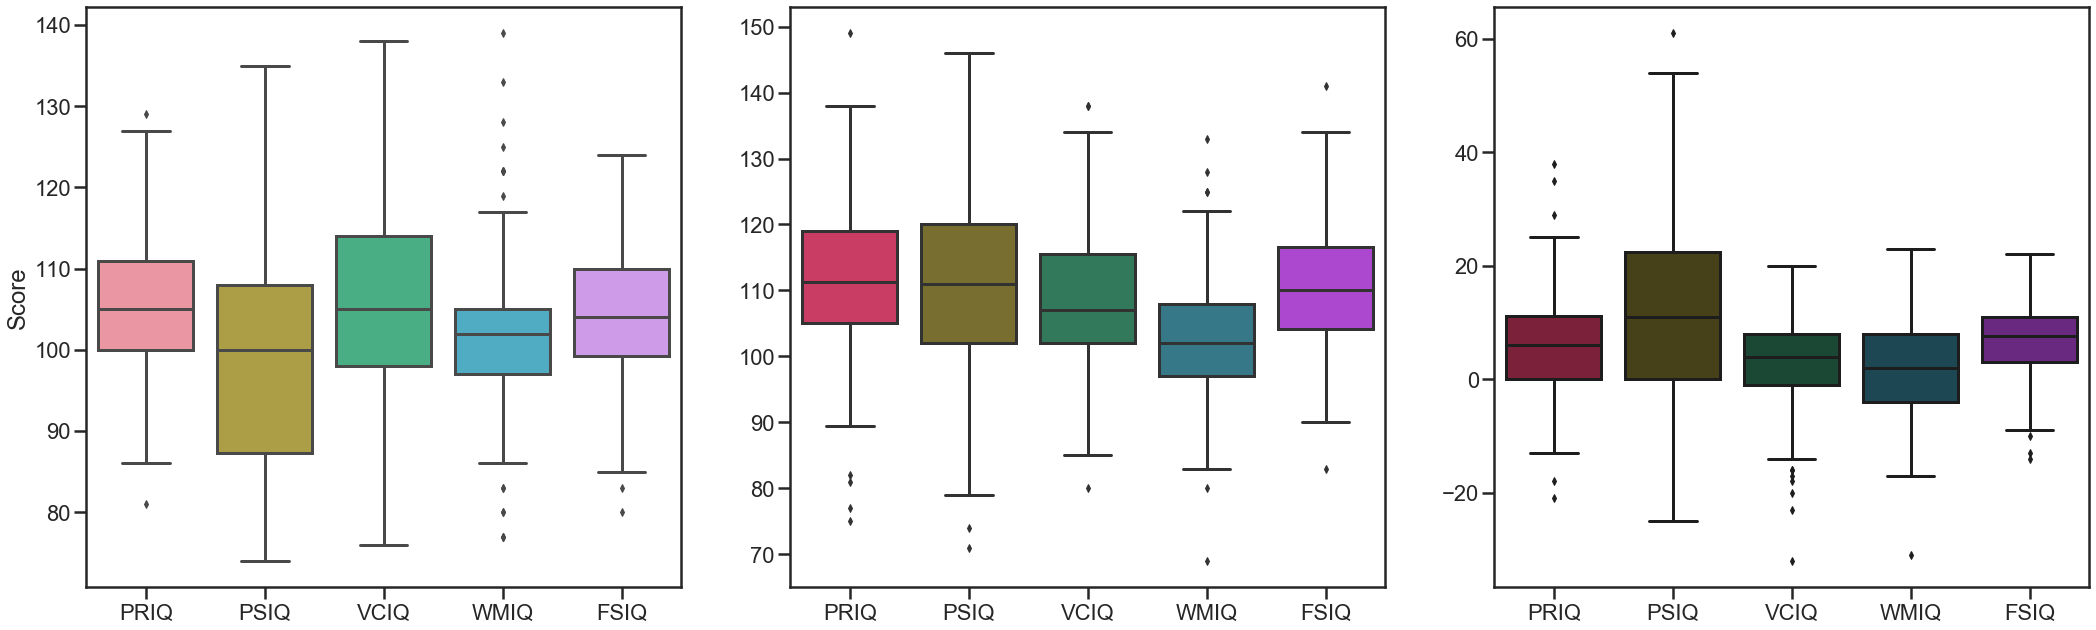

In [41]:
fig,ax = plt.subplots(ncols=3, sharey=False, figsize=(30, 10))
plt.tight_layout(pad=2)
h = sns.boxplot(x='IQ', y='value', data=all_iq_long[all_iq_long['Session'] == 'Post'], 
                order=['Perceptual Reasoning', 'Processing Speed', 'Verbal Comprehension',
                       'Working Memory', 'Full Scale IQ'], 
                ax=ax[1], palette=dark_hsl)
g = sns.boxplot(x='IQ', y='value', data=all_iq_long[all_iq_long['Session'] == 'Pre'], 
                order=['Perceptual Reasoning', 'Processing Speed', 'Verbal Comprehension',
                       'Working Memory', 'Full Scale IQ'], 
                ax=ax[0], palette=light_hsl)
i = sns.boxplot(x='IQ', y='value', data=all_iq_long[all_iq_long['Session'] == 'Delta'], 
                order=['Perceptual Reasoning', 'Processing Speed', 'Verbal Comprehension',
                       'Working Memory', 'Full Scale IQ'], 
                ax=ax[2], palette=darker_hsl)
g.set_xticklabels(['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ'])
h.set_xticklabels(['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ'])
i.set_xticklabels(['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ'])
g.set_xlabel('')
h.set_xlabel('')
i.set_xlabel('')
g.set_ylabel('Score')
h.set_ylabel('')
i.set_ylabel('')
sns.despine()
fig.savefig(join(fig_dir, 'SI1_box_imp.png'), dpi=300)

## Does IQ significantly change over the course of the semester for all students?

In [42]:
mc_alpha,_ = liji_sidak_mc(all_df[['PRI1', 'WMI1',
                                   'PSI1', 'FSIQ1',
                                   'VCI2', 'PRI2',
                                   'WMI2', 'PSI2', 'FSIQ2',
                                   'deltaVCI', 'deltaPRI',
                                   'deltaWMI', 'deltaPSI', 'deltaFSIQ']], 
                           0.05)

Number of effective comparisons: 7.627750184856619
Critical value of 0.050 becomes 0.006702 after corrections


In [43]:
deltas = {}
for iq in iqs:
    deltas['{0}mean'.format(iq)] = np.mean(all_df['delta{0}'.format(iq)])
    deltas['{0}sdev'.format(iq)] = np.std(all_df['delta{0}'.format(iq)])

In [44]:
deltas

{'VCImean': 2.490065607238317,
 'VCIsdev': 8.952232234352552,
 'PRImean': 6.037134884959482,
 'PRIsdev': 9.444712843153749,
 'WMImean': 2.040805423765523,
 'WMIsdev': 9.114156400668048,
 'PSImean': 12.640914303796267,
 'PSIsdev': 17.502132666678417,
 'FSIQmean': 7.031771722014326,
 'FSIQsdev': 7.310255072102436}

In [45]:
basso_deltas = {}
basso_deltas['VCImean'] = 115.8 - 111.5
basso_deltas['VCIsdev'] = np.sqrt(11.9**2 + 12.3**2 - 2*11.9*12.3*.85)

basso_deltas['PSImean'] = 116.4 - 109.3
basso_deltas['PSIsdev'] = np.sqrt(13.0**2 + 14.5**2 - 2*13.0*14.5*.80)

basso_deltas['WMImean'] = 108.6 - 106.9
basso_deltas['WMIsdev'] = np.sqrt(12.4**2 + 13.1**2 - 2*12.4*13.1*.84)

basso_deltas['PRImean'] = 114.4 - 106.1
basso_deltas['PRIsdev'] = np.sqrt(14.1**2 + 14.1**2 - 2*14.1*14.1*.86)

basso_deltas['FSIQmean'] = 115.04 - 109.4
basso_deltas['FSIQsdev'] = np.sqrt(11.6**2 + 12.1**2 - 2*11.6*12.1*.90)

In [46]:
estevis_deltas = {}
estevis_deltas['VCImean'] = 118.4 - 114.2
estevis_deltas['VCIsdev'] = np.sqrt(12.8**2 + 14.4**2 - 2*12.8*14.4*.85)

estevis_deltas['PSImean'] = 123.4 - 112.9
estevis_deltas['PSIsdev'] = np.sqrt(10.7**2 + 13.6**2 - 2*10.7*13.6*.72)

estevis_deltas['WMImean'] = 108.9 - 105.7
estevis_deltas['WMIsdev'] = np.sqrt(11.4**2 + 12.2**2 - 2*11.4*12.2*.92)

estevis_deltas['PRImean'] = 111. - 107.4
estevis_deltas['PRIsdev'] = np.sqrt(10.**2 + 9.1**2 - 2*9.1*10.*.83)

estevis_deltas['FSIQmean'] = 119.1 - 112.4
estevis_deltas['FSIQsdev'] = np.sqrt(11.5**2 + 8.4**2 - 2*11.5*8.4*.91)

In [47]:
basso_deltas

{'VCImean': 4.299999999999997,
 'VCIsdev': 6.638599249841794,
 'PSImean': 7.1000000000000085,
 'PSIsdev': 8.811923740024081,
 'WMImean': 1.6999999999999886,
 'WMIsdev': 7.2436731014037345,
 'PRImean': 8.300000000000011,
 'PRIsdev': 7.461018697202147,
 'FSIQmean': 5.640000000000001,
 'FSIQsdev': 5.321841786449505}

In [48]:
diff_from_basso = {}
diff_from_estevis = {}
for iq in iqs:
    diff_from_basso[iq] = ttest_ind_from_stats(deltas['{0}mean'.format(iq)], 
                                               deltas['{0}sdev'.format(iq)], len(subjects),
                                               basso_deltas['{0}mean'.format(iq)], 
                                               basso_deltas['{0}sdev'.format(iq)], 51,
                                               equal_var=False)
    diff_from_estevis[iq] = ttest_ind_from_stats(deltas['{0}mean'.format(iq)], 
                                               deltas['{0}sdev'.format(iq)], len(subjects),
                                               estevis_deltas['{0}mean'.format(iq)], 
                                               estevis_deltas['{0}sdev'.format(iq)], 51,
                                               equal_var=False)

In [49]:
diff_from_basso

{'VCI': Ttest_indResult(statistic=-1.4850518344789028, pvalue=0.14009017342032953),
 'PRI': Ttest_indResult(statistic=-1.6946621447647685, pvalue=0.09283797644122868),
 'WMI': Ttest_indResult(statistic=0.26350423625889363, pvalue=0.7926350305634552),
 'PSI': Ttest_indResult(statistic=2.806773632583552, pvalue=0.005595917391114943),
 'FSIQ': Ttest_indResult(statistic=1.4134247628639254, pvalue=0.16001226950593575)}

In [50]:
diff_from_estevis

{'VCI': Ttest_indResult(statistic=-1.290492351403755, pvalue=0.19965623554230968),
 'PRI': Ttest_indResult(statistic=2.1260571521329976, pvalue=0.03513219703298411),
 'WMI': Ttest_indResult(statistic=-1.1088759675071445, pvalue=0.2691043306410233),
 'PSI': Ttest_indResult(statistic=1.052535293736242, pvalue=0.2941293428223636),
 'FSIQ': Ttest_indResult(statistic=0.34153671319524004, pvalue=0.7332587196832743)}

In [51]:
mc_alpha,_ = liji_sidak_mc(all_df[['deltaVCI', 'deltaPRI',
                                   'deltaWMI', 'deltaPSI', 'deltaFSIQ']], 
                           0.05)

Number of effective comparisons: 3.6722869656328196
Critical value of 0.050 becomes 0.013871 after corrections


In [52]:
coursetype = ['All', 'Modeling', 'Lecture']

delta_tests = pd.DataFrame(index=pd.MultiIndex.from_product((iqs, coursetype)), 
                           columns=['delta', 'sdev(delta)', 't(delta)', 'p(t)', 'w+', 'p(w+)'])
for i in iqs:
    delta_iq = ttest_rel(all_df['{0}2'.format(i)], all_df['{0}1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'All'), 'delta'] = np.average(all_df['{0}2'.format(i)].dropna())-np.average(all_df['{0}1'.format(i)].dropna())
    delta_tests.at[(i, 'All'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'All'), 'p(t)'] = delta_iq.pvalue

    delta_tests.at[(i, 'All'), 'sdev(delta)'] = np.std(all_df['delta{0}'.format(i)])
    delta_tests.at[(i, 'Modeling'), 'sdev(delta)'] = np.std(all_df[all_df['Class.Type'] == 'Mod']['delta{0}'.format(i)])
    delta_tests.at[(i, 'Lecture'), 'sdev(delta)'] = np.std(all_df[all_df['Class.Type'] == 'Lec']['delta{0}'.format(i)])

    delta_iq = ttest_rel(all_df[all_df['Class.Type'] == 'Mod']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Mod']['{0}1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'Modeling'), 'delta'] = np.average(all_df[all_df['Class.Type'] == 'Mod']['{0}2'.format(i)].dropna())-np.average(all_df[all_df['Class.Type'] == 'Mod']['{0}1'.format(i)].dropna())
    delta_tests.at[(i, 'Modeling'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'Modeling'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = ttest_rel(all_df[all_df['Class.Type'] == 'Lec']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Lec']['{0}1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'Lecture'), 'delta'] = np.average(all_df[all_df['Class.Type'] == 'Lec']['{0}2'.format(i)].dropna())-np.average(all_df[all_df['Class.Type'] == 'Lec']['{0}1'.format(i)].dropna())
    delta_tests.at[(i, 'Lecture'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'Lecture'), 'p(t)'] = delta_iq.pvalue
    

    
    delta_iq = wilcoxon(all_df['{0}2'.format(i)], all_df['{0}1'.format(i)])
    delta_tests.at[(i, 'All'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'All'), 'p(w+)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(all_df[all_df['Class.Type'] == 'Mod']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Mod']['{0}1'.format(i)])
    delta_tests.at[(i, 'Modeling'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'Modeling'), 'p(w+)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(all_df[all_df['Class.Type'] == 'Lec']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Lec']['{0}1'.format(i)])
    delta_tests.at[(i, 'Lecture'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'Lecture'), 'p(w+)'] = delta_iq.pvalue
    
        
delta_tests.to_csv(join(data_dir, 'rescored', 'change-in-iq_imp.csv'))

In [53]:
delta_tests

delta sdev(delta)  t(delta)         p(t)      w+  \
VCI  All        2.43611     8.95223   2.96755   0.00357885  2214.5   
     Modeling   2.83255     7.90363   2.66367   0.00980166     533   
     Lecture    2.05169     9.85666   1.63904     0.106038   588.5   
PRI  All        6.47178     9.44471   7.17349  5.09265e-11  1319.5   
     Modeling   6.69958     8.93186   5.39522   1.0991e-06     300   
     Lecture    6.25089      9.9119   4.75114  1.15816e-05     362   
WMI  All       0.954111     9.11416   1.04874     0.296257  2966.5   
     Modeling   1.05643     9.41775    0.8617     0.392121   618.5   
     Lecture   0.854895     8.80528  0.633253      0.52879     900   
PSI  All        12.3222     17.5021   8.08551  3.90622e-13    1033   
     Modeling   16.1626     17.4159   7.48746   2.8135e-10     124   
     Lecture    8.59824     16.7994   4.16282  9.43507e-05     407   
FSIQ All        6.90267     7.31026   10.0113  8.26472e-18     822   
     Modeling   8.24477     6.30617   9.01882  6.00744e-13      50   
     Lecture    5.60123     8.03391   5.54615  5.73944e-07     384   

                     p(w+)  
VCI  All       0.000498142  
     Modeling   0.00489785  
     Lecture     0.0386446  
PRI  All       3.03249e-10  
     Modeling  2.05813e-06  
     Lecture    2.7555e-05  
WMI  All          0.186826  
     Modeling     0.285208  
     Lecture      0.459385  
PSI  All       1.02975e-11  
     Modeling  3.60197e-09  
     Lecture    0.00030767  
FSIQ All       6.04577e-15  
     Modeling  8.09338e-11  
     Lecture   6.76965e-06

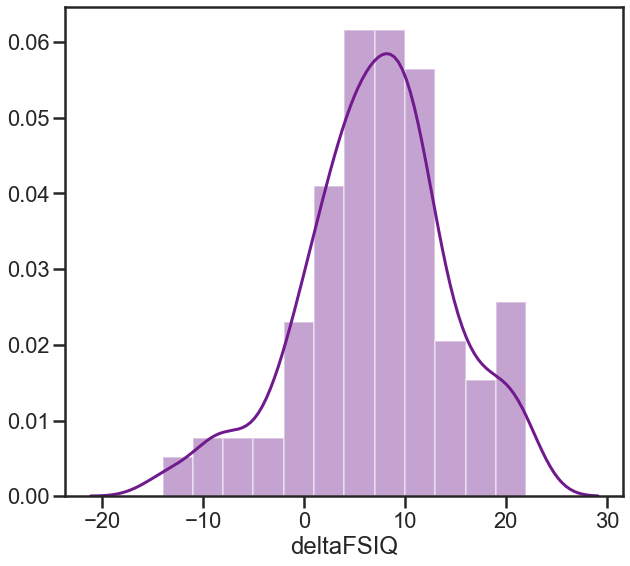

In [54]:
fig,ax = plt.subplots(figsize=(10,9))
sns.distplot(all_df['deltaFSIQ'].dropna(), color=darker_hsl[4])
sns.despine()
fig.savefig(join(fig_dir, 'SI-1_fsiq_imp.png'), dpi=300)

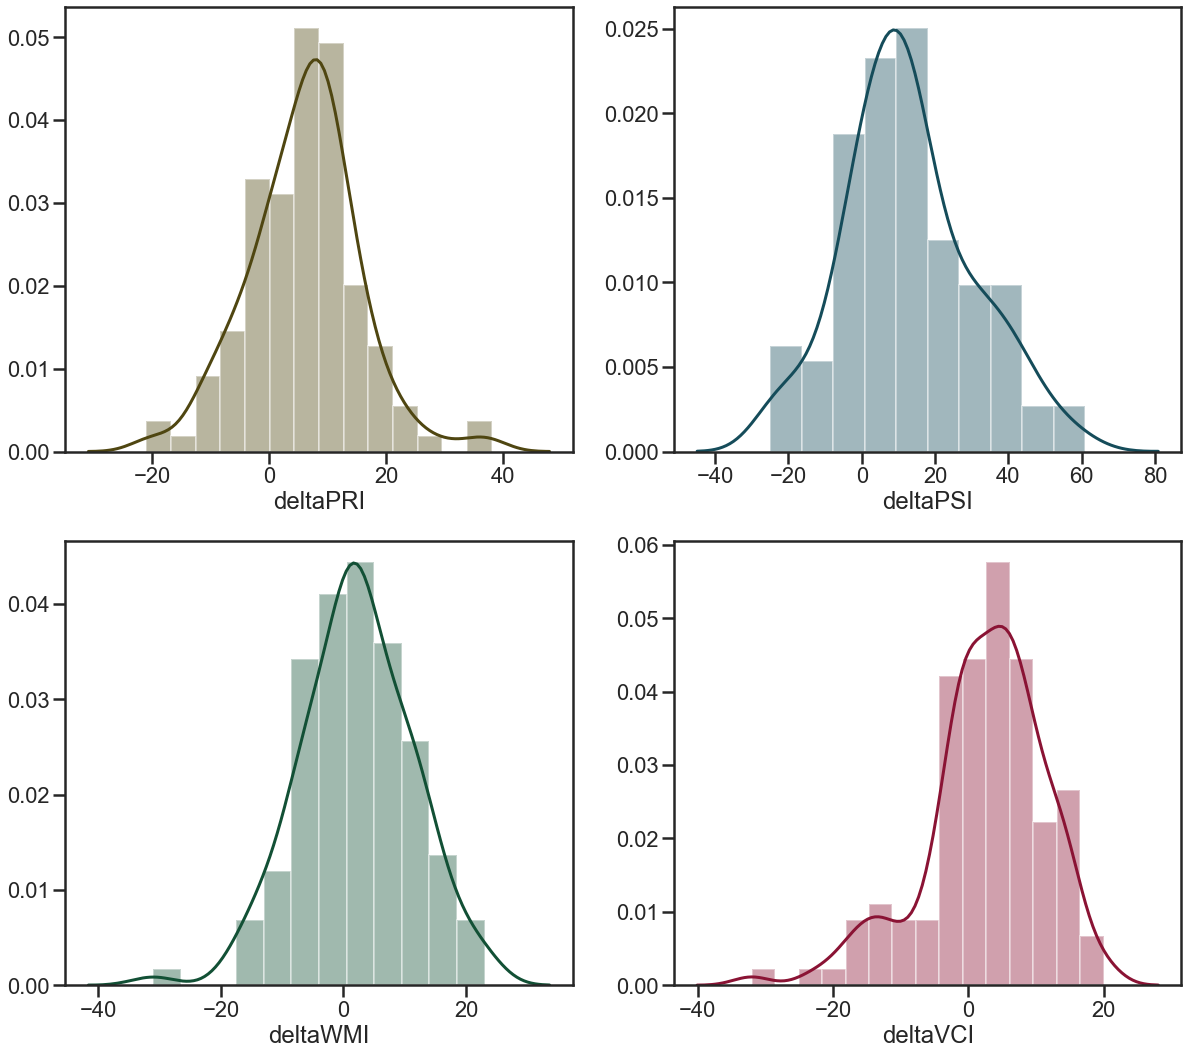

In [55]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(20,18))
sns.distplot(all_df['deltaPRI'].dropna(), ax=ax[0][0], color=darker_hsl[1])
sns.distplot(all_df['deltaPSI'].dropna(), ax=ax[0][1], color=darker_hsl[3])
sns.distplot(all_df['deltaWMI'].dropna(), ax=ax[1][0], color=darker_hsl[2])
sns.distplot(all_df['deltaVCI'].dropna(), ax=ax[1][1], color=darker_hsl[0])
sns.despine()
fig.savefig(join(fig_dir, 'SI-1_histograms_imp.png'), dpi=300)

In [56]:
df_f = all_df[all_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = all_df[all_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

## Are there significant sex differences in IQ?

In [57]:
sessions = ['pre', 'post']
coursetype = ['All', 'Modeling', 'Lecture']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sessions, iqs, coursetype), 
                                                            names=['session', 'iq', 'course']),
                           columns=['t(diff)', 'p(t)', 'U', 'p(U)'])

for i in np.arange(0, len(sessions)):
    for iq in iqs:
        delta_iq = ttest_ind(df_f['{0}{1}'.format(iq, i+1)], df_m['{0}{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'All'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f['{0}{1}'.format(iq, i+1)], df_m['{0}{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'p(U)'] = delta_iq.pvalue

        delta_iq = ttest_ind(df_f[df_f['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f[df_f['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'p(U)'] = delta_iq.pvalue

        delta_iq = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'p(U)'] = delta_iq.pvalue
        

In [58]:
sex_diff_iq.to_csv(join(data_dir, 'rescored', 'sex_differences_pre_post_iq_imp.csv'))
sex_diff_iq

t(diff)         p(t)       U         p(U)
session iq   course                                              
pre     VCI  All       -2.64572   0.00917362  1432.5  0.000855637
             Modeling  -2.81847   0.00646786     274   0.00132707
             Lecture     -1.364     0.177345   405.5    0.0395441
        PRI  All       -2.64795   0.00911668    1533   0.00381405
             Modeling  -1.35131     0.181505     390    0.0781638
             Lecture   -2.32815    0.0230767   371.5    0.0140743
        WMI  All       -1.20992     0.228539  1841.5     0.108653
             Modeling  -0.30664     0.760145     477     0.409711
             Lecture   -1.40603     0.164553     430    0.0739938
        PSI  All        1.04215     0.299305    1859     0.126075
             Modeling  0.364596     0.716654     463     0.338014
             Lecture   0.997365     0.322343     463     0.154288
        FSIQ All       -2.63919   0.00934276    1543   0.00437901
             Modeling  -2.05398    0.0442007   329.5    0.0123039
             Lecture   -1.97854    0.0521754   405.5    0.0394877
post    VCI  All       -3.09192   0.00244129    1464   0.00139712
             Modeling  -3.21206   0.00209094   270.5   0.00112951
             Lecture   -1.65763     0.102287     433    0.0804324
        PRI  All       -3.78398  0.000235995  1317.5  0.000119408
             Modeling  -3.20956   0.00210654   285.5      0.00219
             Lecture   -2.11976    0.0379099     362    0.0102965
        WMI  All       -2.07752     0.039753    1667    0.0202018
             Modeling   -1.3906     0.169317   363.5    0.0366198
             Lecture   -1.57365     0.120499   460.5     0.146411
        PSI  All       0.493879     0.622238  1996.5     0.307786
             Modeling  0.679186     0.499548   404.5     0.111386
             Lecture   0.456742     0.649403   523.5     0.405915
        FSIQ All       -3.39245  0.000922132    1458   0.00128247
             Modeling  -2.75172   0.00776339     322   0.00948873
             Lecture   -1.94123    0.0566369     394    0.0285134

## Significant changes in IQ pre- to post-instruction, separated by sex

In [59]:
sessions = ['pre', 'post']
coursetype = ['All', 'Mod', 'Lec', 'Difference (Lec - Mod)']
sexes = ['Female', 'Male']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sexes, iqs, coursetype), 
                                                            names=['Sex', 'iq', 'course']), 
                           columns=['t(diff)', 'p(t)', 'np', 'p(np)'])

for iq in iqs:
    
    delta_iq = ttest_rel(df_f['{0}2'.format(iq)], df_f['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'All'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class.Type'] == 'Mod']['{0}2'.format(iq)], df_f[df_f['Class.Type'] == 'Mod']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Mod'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Mod'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class.Type'] == 'Lec']['{0}2'.format(iq)], df_f[df_f['Class.Type'] == 'Lec']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Lec'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Lec'), 'p(t)'] = delta_iq.pvalue
    
    
    delta_iq = wilcoxon(df_f['{0}2'.format(iq)], df_f['{0}1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'All'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'All'), 'p(np)'] = delta_iq.pvalue

    delta_iq = wilcoxon(df_f[df_f['Class.Type'] == 'Mod']['{0}2'.format(iq)], 
                        df_f[df_f['Class.Type'] == 'Mod']['{0}1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'Mod'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Mod'), 'p(np)'] = delta_iq.pvalue

    delta_iq = wilcoxon(df_f[df_f['Class.Type'] == 'Lec']['{0}2'.format(iq)], 
                        df_f[df_f['Class.Type'] == 'Lec']['{0}1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'Lec'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Lec'), 'p(np)'] = delta_iq.pvalue
    

    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(iq)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(iq)])
   
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq_p.pvalue
    
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'p(np)'] = delta_iq_np.pvalue
    
    delta_iq = ttest_rel(df_m['{0}2'.format(iq)], df_m['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'All'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m['{0}2'.format(iq)], df_m['{0}1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'All'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'All'), 'p(np)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class.Type'] == 'Mod']['{0}2'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Mod']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Mod'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Mod'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m[df_m['Class.Type'] == 'Mod']['{0}2'.format(iq)], 
                        df_m[df_m['Class.Type'] == 'Mod']['{0}1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Mod'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Mod'), 'p(np)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class.Type'] == 'Lec']['{0}2'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Lec']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Lec'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Lec'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m[df_m['Class.Type'] == 'Lec']['{0}2'.format(iq)], 
                        df_m[df_m['Class.Type'] == 'Lec']['{0}1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Lec'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Lec'), 'p(np)'] = delta_iq.pvalue

    delta_iq_p = ttest_ind(df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(iq)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq_p.pvalue
    
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'p(np)'] = delta_iq_np.pvalue

In [60]:
sex_diff_iq

t(diff)         p(t)     np        p(np)
Sex    iq   course                                                           
Female VCI  All                      2.13061    0.0372291  483.5    0.0102613
            Mod                      2.03898    0.0521573     83    0.0322945
            Lec                      1.16126     0.253623  167.5      0.11444
            Difference (Lec - Mod) -0.606096     0.546776    442     0.427592
       PRI  All                      3.98034  0.000188245  378.5  0.000219458
            Mod                      2.07167    0.0487642   90.5    0.0520457
            Lec                      3.41348   0.00167392  108.5   0.00211034
            Difference (Lec - Mod)  0.795031     0.429782    376     0.125796
       WMI  All                     0.118856     0.905787  727.5     0.721581
            Mod                    -0.407289     0.687262  113.5     0.672437
            Lec                     0.462969     0.646337  224.5      0.31676
            Difference (Lec - Mod)   1.27453     0.207473    368     0.103286
       PSI  All                        4.692  1.61066e-05  292.5  6.30279e-05
            Mod                      4.48046  0.000143266   23.5  0.000300963
            Lec                      2.43567    0.0202584  137.5    0.0303278
            Difference (Lec - Mod)  -1.73559    0.0878563    344    0.0534193
       FSIQ All                      6.17669  6.21546e-08    218  4.74944e-07
            Mod                       4.8104  6.09009e-05     25  0.000212598
            Lec                      4.04542  0.000284236    103  0.000877369
            Difference (Lec - Mod) -0.564655     0.574449  448.5     0.465106
Male   VCI  All                      2.05087    0.0441361  635.5    0.0167567
            Mod                      1.75079    0.0882701  198.5    0.0562163
            Lec                      1.14183     0.262556    133     0.178245
            Difference (Lec - Mod)   0.15427      0.87786  549.5     0.318764
       PRI  All                      6.10314  5.60967e-08    276  1.91077e-07
            Mod                      5.33073  5.05773e-06     61  1.15953e-05
            Lec                      3.25188   0.00283221   77.5   0.00424706
            Difference (Lec - Mod) -0.850182     0.398252  512.5     0.179435
       WMI  All                      1.33351     0.186816    762     0.132322
            Mod                      1.46839     0.150449    165    0.0639263
            Lec                     0.424994     0.673874  218.5     0.773094
            Difference (Lec - Mod) -0.642248     0.522904  479.5    0.0939835
       PSI  All                       6.9389  1.82722e-09  189.5  7.83088e-09
            Mod                      6.02356  5.83395e-07     40  2.58997e-06
            Lec                      3.72535  0.000807403   56.5   0.00084626
            Difference (Lec - Mod)  -1.65238     0.103136    464    0.0664262
       FSIQ All                      7.94031  2.81272e-11  192.5  2.05608e-09
            Mod                      7.79545  2.53876e-09      2  1.32822e-07
            Lec                      3.75602  0.000743105   89.5   0.00188553
            Difference (Lec - Mod)  -1.48821     0.141387    498     0.137284

# Sex differences in the change in IQ

In [61]:
#sex differences (F>M) in the change in IQ

sessions = ['pre', 'post']
coursetype = ['All', 'Mod', 'Lec']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((iqs, coursetype), 
                                                            names=['iq', 'course']), 
                           columns=['t(diff)', 'p(t)', 'np', 'p(np)'])

for iq in iqs:
    i = iq
    #both classes
    delta_iq_p = ttest_ind(df_f['delta{0}'.format(i)],
                           df_m['delta{0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f['delta{0}'.format(i)],
                               df_m['delta{0}'.format(i)])

    sex_diff_iq.at[(iq, 'All'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'All'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'All'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'All'), 'p(np)'] = delta_iq_np.pvalue

    #Lecture
    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(i)],
                           df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(i)],
                               df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(i)])
    sex_diff_iq.at[(iq, 'Lec'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'Lec'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'Lec'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'Lec'), 'p(np)'] = delta_iq_np.pvalue

    #Modeling
    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(i)],
                           df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(i)],
                               df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(i)])

    sex_diff_iq.at[(iq, 'Mod'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'Mod'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'Mod'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'Mod'), 'p(np)'] = delta_iq_np.pvalue

In [62]:
sex_diff_iq.to_csv(join(data_dir, 'rescored', 'sex_differences_in_IQ_imp.csv'))
sex_diff_iq

t(diff)       p(t)      np      p(np)
iq   course                                         
VCI  All     0.0498346   0.960332    2081   0.457234
     Mod      0.532142    0.59653   464.5   0.345746
     Lec     -0.299242   0.765725   519.5    0.38611
PRI  All      -1.63797   0.103885    1758  0.0530956
     Mod      -2.10866  0.0390209     313  0.0067184
     Lec     -0.328421   0.743666     536   0.469255
WMI  All      -1.14809   0.253071    1892   0.161035
     Mod      -1.77068  0.0815293   350.5   0.025008
     Lec       0.10023   0.920475     501   0.298979
PSI  All     -0.455274   0.649683  2009.5   0.329579
     Mod      0.157467   0.875389   483.5   0.445616
     Lec     -0.387005   0.700037   512.5   0.352209
FSIQ All      -1.49072   0.138496  1758.5  0.0533899
     Mod      -1.52971   0.131175     379  0.0585596
     Lec     -0.476127   0.635606     507   0.326354

## differences in the change in IQ wrt sex and class
(the regression approach)

In [63]:
#making dummy variables for class type
class_dumb = pd.get_dummies(df_f['Class.Type'])
df_f = pd.concat((df_f, class_dumb), axis=1)

class_dumb = pd.get_dummies(df_m['Class.Type'])
df_m = pd.concat((df_m, class_dumb), axis=1)

class_dumb = pd.get_dummies(all_df['Class.Type'])
all_df = pd.concat((all_df, class_dumb), axis=1)

In [64]:
dumb = pd.get_dummies(all_df['Sex'])
all_df['F'] = dumb['F']

In [65]:
all_df['SexXClass'] = (all_df['F'] + 1) * (all_df['Mod'] + 1)

In [66]:
for iq_meas in iqs:
    df_f['{0}1XClass'.format(iq_meas)] = df_f['{0}1'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_f['{0}2XClass'.format(iq_meas)] = df_f['{0}2'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_m['{0}1XClass'.format(iq_meas)] = df_m['{0}1'.format(iq_meas)] * (df_m['Mod'] + 1)
    df_m['{0}2XClass'.format(iq_meas)] = df_m['{0}2'.format(iq_meas)] * (df_m['Mod'] + 1)
    all_df['{0}1XClass'.format(iq_meas)] = all_df['{0}1'.format(iq_meas)] * (all_df['Mod'] + 1)
    all_df['{0}2XClass'.format(iq_meas)] = all_df['{0}2'.format(iq_meas)] * (all_df['Mod'] + 1)

    df_f['delta{0}XClass'.format(iq_meas)] = df_f['delta{0}'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_m['delta{0}XClass'.format(iq_meas)] = df_m['delta{0}'.format(iq_meas)] * (df_m['Mod'] + 1)
    all_df['delta{0}XClass'.format(iq_meas)] = all_df['delta{0}'.format(iq_meas)] * (all_df['Mod'] + 1)


In [67]:
for iq_meas in iqs:
    all_df['{0}1XClassXSex'.format(iq_meas)] = all_df['{0}1XClass'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['{0}1XSex'.format(iq_meas)] = all_df['{0}1'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['{0}2XClassXSex'.format(iq_meas)] = all_df['{0}1XClass'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['{0}2XSex'.format(iq_meas)] = all_df['{0}1'.format(iq_meas)] * (all_df['F'] + 1)

    all_df['delta{0}XClassXSex'.format(iq_meas)] = all_df['delta{0}XClass'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['delta{0}XSex'.format(iq_meas)] = all_df['delta{0}'.format(iq_meas)] * (all_df['F'] + 1)
   

In [68]:
sexes = ['Male', 'Female', 'All']


In [69]:
p_corr,_ = liji_sidak_mc(all_df, 0.05)


Number of effective comparisons: 21.197661010363625
Critical value of 0.050 becomes 0.002417 after corrections


In [70]:
#let's use regressions instead
index = pd.MultiIndex.from_product((sexes,iqs))
iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'Class_pval'])

for iq_meas in iqs:
    y = all_df['delta{0}'.format(iq_meas)]
    
    x = all_df[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('All', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('All', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('All', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('All', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('All', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]
    if grade_on_delta_iq.f_pvalue < p_corr:
        print(grade_on_delta_iq.summary())
    
    y = df_m['delta{0}'.format(iq_meas)]
    
    x = df_m[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_pre_iq = reg1.fit()
    iqXclassXsex.at[('Male', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
    iqXclassXsex.at[('Male', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
    iqXclassXsex.at[('Male', iq_meas), 'AIC'] = grade_on_pre_iq.aic
    iqXclassXsex.at[('Male', iq_meas), 'BIC'] = grade_on_pre_iq.bic
    iqXclassXsex.at[('Male', iq_meas), 'Class_pval'] = grade_on_pre_iq.pvalues[1]
    if grade_on_pre_iq.f_pvalue < p_corr:
        print(grade_on_pre_iq.summary())
    
    y = df_f['delta{0}'.format(iq_meas)]
    
    x = df_f[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('Female', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('Female', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('Female', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('Female', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('Female', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]
    if grade_on_delta_iq.f_pvalue < p_corr:
        print(grade_on_delta_iq.summary())
iqXclassXsex.to_csv(join(data_dir, 'rescored', 'IQ_on_Class_Age_Strt.csv'))
iqXclassXsex

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


F-statistic Prob (F-statistic)      AIC      BIC Class_pval
Male   VCI     0.497551           0.685267  497.559  506.495    0.81438
       PRI     0.952035           0.420803  507.781  516.718   0.456861
       WMI       4.3026         0.00786876  495.512  504.448   0.657057
       PSI      1.16762           0.328932  580.477  589.413   0.114512
       FSIQ     3.31182          0.0253782   465.89  474.827   0.177962
Female VCI     0.986484           0.405678   451.89  460.333   0.655909
       PRI     0.807112           0.495145  452.725  461.169    0.46298
       WMI      1.05597           0.375014  446.838  455.281   0.186863
       PSI      1.42019           0.246286  537.736   546.18    0.07696
       FSIQ    0.610056           0.611232  422.235  430.678   0.586653
All    VCI      1.27397           0.286227  942.934  954.404   0.835338
       PRI     0.223235           0.880103  960.053  971.523   0.769124
       WMI     0.446031           0.720532  950.106  961.576   0.751793
       PSI      2.28727          0.0818179  1114.23   1125.7  0.0150856
       FSIQ      1.0744           0.362493  890.853  902.323   0.116676

In [71]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])


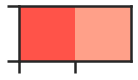

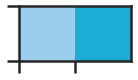

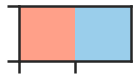

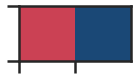

In [72]:
sns.palplot(f_2)
sns.palplot(m_2)

sns.palplot(crayons_l)
sns.palplot(crayons_d)

In [73]:
corrfonty = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'center',
             'horizontalalignment': 'right'}
corrfontx = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'top',
             'horizontalalignment': 'center'}

In [74]:
fs_long.head()


,Sex,Subject,Class.Type,Session,Full Scale IQ,IQ
0,F,101,Lec,Pre,94.0,Full Scale IQ
1,M,102,Mod,Pre,104.0,Full Scale IQ
2,M,103,Lec,Pre,98.0,Full Scale IQ
3,F,104,Mod,Pre,103.0,Full Scale IQ
4,M,105,Lec,Pre,110.0,Full Scale IQ


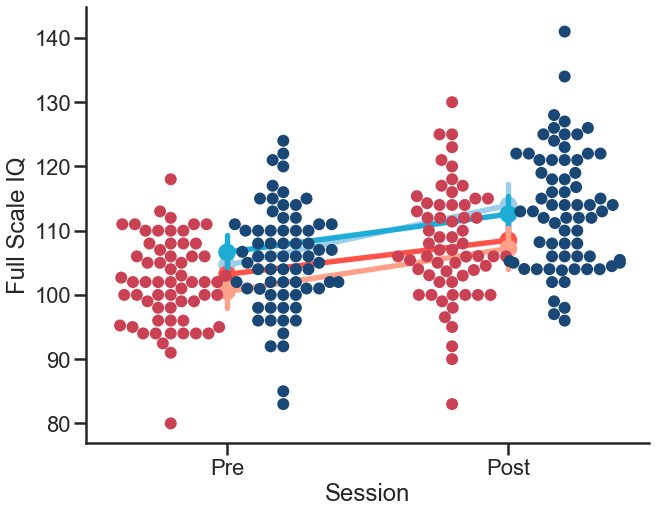

In [75]:
#sns.set_style('whitegrid')

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
plt.tight_layout(pad=5)
mksz = 12
k = sns.swarmplot(x='Session', y='Full Scale IQ', hue='Sex', data=fs_long[fs_long['Session'] != 'Delta'], palette=crayons_d, dodge=True, ax=ax, size=mksz)
k.get_legend().set_visible(False)
sns.despine()

prepost_df = fs_long[fs_long['Session'] != 'Delta']
j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Class.Type', data=prepost_df[prepost_df['Sex'] == 'M'], ax=ax, palette=m_2)
j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Class.Type', data=prepost_df[prepost_df['Sex'] == 'F'], ax=ax, palette=f_2)
j.get_legend().set_visible(False)
sns.despine()
fig.savefig('/Users/katherine/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ+SCALED_imp.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/katherine/Dropbox/Projects/physics-retrieval/figures/figure1_change-vcIQ_imp.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/katherine/Dropbox/Projects/physics-retrieval/figures/figure1_change-prIQ_imp.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/katherine/Dropbox/Projects/physics-retrieval/figures/figure1_change-wmIQ_imp.png', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
mksz = 10
plt.tight_layout(pad=5)
k = sns.pointplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/katherine/Dropbox/Projects/physics-retrieval/figures/figure1_change-psIQ_imp.png', dpi=300)

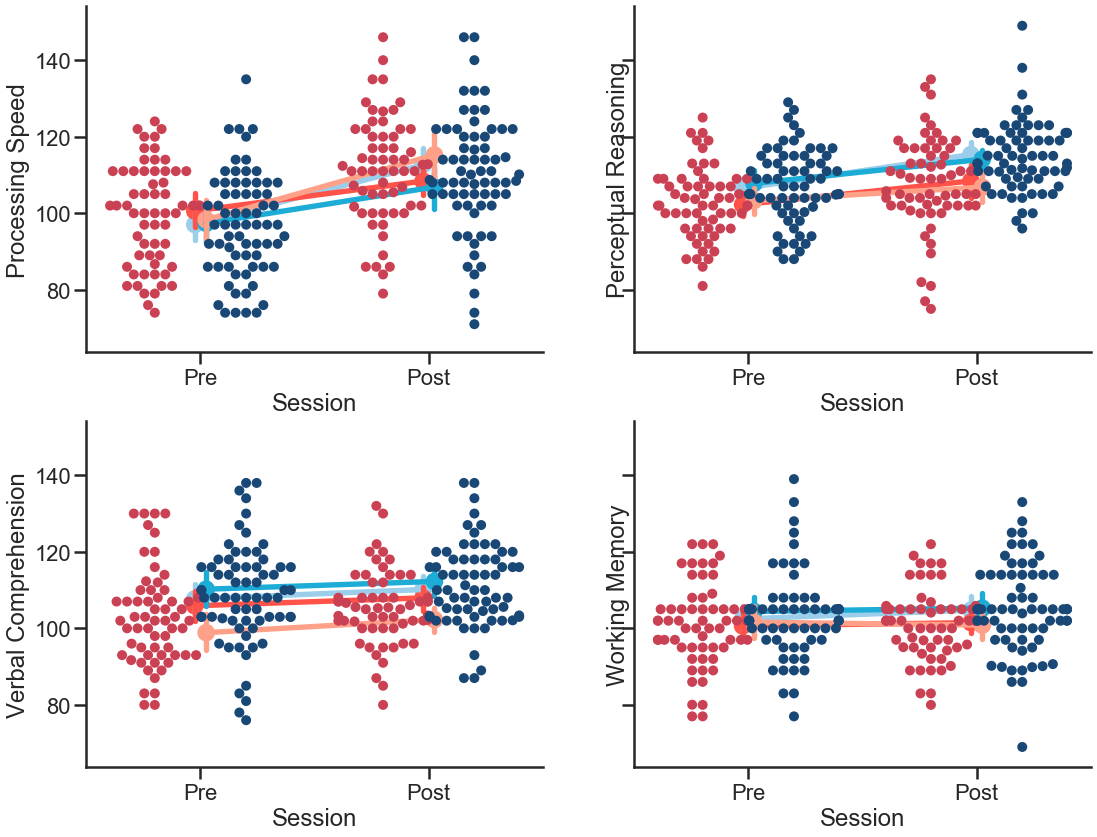

In [76]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 14), sharey=True, squeeze=True)
mksz = 10
#plt.tight_layout(pad=5)

prepost_pr = pr_long[pr_long['Session'] != 'Delta']
prepost_ps = ps_long[ps_long['Session'] != 'Delta']
prepost_vc = vc_long[vc_long['Session'] != 'Delta']
prepost_wm = wm_long[wm_long['Session'] != 'Delta']

h = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Class.Type', data=prepost_pr[prepost_pr['Sex'] == 'M'], 
              palette=m_2, ax=ax[0][1], dodge=True)
h = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Class.Type', data=prepost_pr[prepost_pr['Sex'] == 'F'], 
              palette=f_2, ax=ax[0][1], size=mksz, dodge=True)
h.get_legend().set_visible(False)


i = sns.pointplot(x='Session', y='Processing Speed', hue='Class.Type', data=prepost_ps[prepost_ps['Sex'] == 'M'], 
              palette=m_2, ax=ax[0][0], size=mksz, dodge=True)
i = sns.pointplot(x='Session', y='Processing Speed', hue='Class.Type', data=prepost_ps[prepost_ps['Sex'] == 'F'], 
              palette=f_2, ax=ax[0][0], size=mksz, dodge=True)
i.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Class.Type', data=prepost_vc[prepost_vc['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][0], size=mksz, dodge=True)
j = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Class.Type', data=prepost_vc[prepost_vc['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][0], size=mksz, dodge=True)
j.get_legend().set_visible(False)

k = sns.pointplot(x='Session', y='Working Memory', hue='Class.Type', data=prepost_wm[prepost_wm['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][1], size=mksz, dodge=True)
k = sns.pointplot(x='Session', y='Working Memory', hue='Class.Type', data=prepost_wm[prepost_wm['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][1], size=mksz, dodge=True)
k.get_legend().set_visible(False)


h = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=prepost_pr, 
              palette=crayons_d, ax=ax[0][1], size=mksz, dodge=True)
h.get_legend().set_visible(False)
i = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=prepost_wm, 
              palette=crayons_d, ax=ax[1][1], size=mksz, dodge=True)
i.get_legend().set_visible(False)
j = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=prepost_ps, 
              palette=crayons_d, ax=ax[0][0], size=mksz, dodge=True)
j.get_legend().set_visible(False)
k = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=prepost_vc, 
              palette=crayons_d, ax=ax[1][0], size=mksz, dodge=True)
k.get_legend().set_visible(False)

sns.despine()
fig.savefig('/Users/katherine/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ-subscores+SCALED_imp.png', dpi=300)


## Does IQ facilitate learning?
Is pre-instruction IQ significantly related to academic performance or change in physics knowledge/reasoning?

## Does IQ reflect learning?
Is the change in IQ over the duration of the course related to academic performance or change in physics knowledge/reasoning?

In [77]:
sessions.append('delta')

In [78]:
mc_alpha,_ = liji_sidak_mc(all_df, 0.05)

Number of effective comparisons: 21.197661010363625
Critical value of 0.050 becomes 0.002417 after corrections


In [79]:
#is there a difference in accuracy/performance between classes?
print('Phy48Grade', ttest_ind(all_df[all_df['Mod'] == 1]['Phy48Grade'], 
                all_df[all_df['Mod'] == 0]['Phy48Grade'], nan_policy='omit'))
print('RetrPhyAcc2', ttest_ind(all_df[all_df['Mod'] == 1]['RetrPhyAcc2'], 
                all_df[all_df['Mod'] == 0]['RetrPhyAcc2'], nan_policy='omit'))
print('FCIPhyAcc2', ttest_ind(all_df[all_df['Mod'] == 1]['FCIPhyAcc2'], 
                all_df[all_df['Mod'] == 0]['FCIPhyAcc2'], nan_policy='omit'))

Phy48Grade Ttest_indResult(statistic=1.7990063153244393, pvalue=0.0743738521270638)
RetrPhyAcc2 Ttest_indResult(statistic=-1.1206916741204158, pvalue=0.2645173761449103)
FCIPhyAcc2 Ttest_indResult(statistic=-0.8613878378726187, pvalue=0.3906352405322713)


In [80]:
outcomes = ['Phy48Grade', 'RetrPhyAcc2', 'FCIPhyAcc2', 
            'deltaRetrPhyAcc', 'deltaFCIPhyAcc']
covariates = ['Age', 'Mod', 'Strt.Level', 'F']


In [81]:
index = pd.MultiIndex.from_product((sessions, iqs))
perf_iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                        'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval', 
                                                        'IQXClass_pval', 'SexXClass_pval', 'IQXSex_pval', 
                                                        'IQXClassXSex_pval'])
for outcome in outcomes:
    for iq_meas in iqs:
        y = all_df[outcome]
        x = all_df[['{0}1'.format(iq_meas), 
                    '{0}1XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}1XSex'.format(iq_meas),
                    '{0}1XClassXSex'.format(iq_meas)
                   ] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_pre_iq = reg1.fit()
        perf_iqXclassXsex.loc[('pre', iq_meas), 'F-statistic'] = perf_on_pre_iq.fvalue
        perf_iqXclassXsex.loc[('pre', iq_meas), 'Prob (F-statistic)'] = perf_on_pre_iq.f_pvalue
        perf_iqXclassXsex.loc[('pre', iq_meas), 'AIC'] = perf_on_pre_iq.aic
        perf_iqXclassXsex.loc[('pre', iq_meas), 'BIC'] = perf_on_pre_iq.bic
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQ_pval'] = perf_on_pre_iq.pvalues['{0}1'.format(iq_meas)] 
        #perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXClass_pval'] = perf_on_pre_iq.pvalues[2]
        #perf_iqXclassXsex.loc[('pre', iq_meas), 'SexXClass_pval'] = perf_on_pre_iq.pvalues[3]
        #perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXSex_pval'] = perf_on_pre_iq.pvalues[4]
        #perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXClassXSex_pval'] = perf_on_pre_iq.pvalues[5]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        
        if perf_on_pre_iq.f_pvalue <= mc_alpha and perf_on_pre_iq.pvalues['{0}1'.format(iq_meas)] <= 0.05:
            print(perf_on_pre_iq.summary())
            print(outcome, 
                  '\t{0}1'.format(iq_meas), 
                  '\tF_model = {0}'.format(np.round(perf_on_pre_iq.f_pvalue, 6)), 
                  '\tp(IQ) = {0}'.format(np.round(perf_on_pre_iq.pvalues['{0}1'.format(iq_meas)],6)),
                  '\tp(IQXClassXSex) = {0}'.format(np.round(perf_on_pre_iq.pvalues['{0}1XClassXSex'.format(iq_meas)], 6)))

        x = all_df[['{0}2'.format(iq_meas), 
                    '{0}2XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}2XSex'.format(iq_meas),
                    '{0}2XClassXSex'.format(iq_meas)
                   ] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_post_iq = reg1.fit()
        perf_iqXclassXsex.loc[('post', iq_meas), 'F-statistic'] = perf_on_post_iq.fvalue
        perf_iqXclassXsex.loc[('post', iq_meas), 'Prob (F-statistic)'] = perf_on_post_iq.f_pvalue
        perf_iqXclassXsex.loc[('post', iq_meas), 'AIC'] = perf_on_post_iq.aic
        perf_iqXclassXsex.loc[('post', iq_meas), 'BIC'] = perf_on_post_iq.bic
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQ_pval'] = perf_on_post_iq.pvalues[1] 
        #perf_iqXclassXsex.loc[('post', iq_meas), 'IQXClass_pval'] = perf_on_post_iq.pvalues[2]
        #perf_iqXclassXsex.loc[('post', iq_meas), 'SexXClass_pval'] = perf_on_post_iq.pvalues[3]
        #perf_iqXclassXsex.loc[('post', iq_meas), 'IQXSex_pval'] = perf_on_post_iq.pvalues[4]
        #perf_iqXclassXsex.loc[('post', iq_meas), 'IQXClassXSex_pval'] = perf_on_post_iq.pvalues[5]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())

        
        if perf_on_post_iq.f_pvalue <= mc_alpha and perf_on_post_iq.pvalues['{0}2'.format(iq_meas)] <= 0.05:
            print(perf_on_post_iq.summary())
            print(outcome, 
                  '\t{0}2'.format(iq_meas), 
                  '\tF_model = {0}'.format(np.round(perf_on_post_iq.f_pvalue, 6)), 
                  '\tp(IQ) = {0}'.format(np.round(perf_on_post_iq.pvalues['{0}2'.format(iq_meas)], 6)),
                  '\tp(IQXClassXSex) = {0}'.format(np.round(perf_on_post_iq.pvalues['{0}2XClassXSex'.format(iq_meas)], 6)))
            
        x = all_df[['delta{0}'.format(iq_meas), 
                    'delta{0}XClass'.format(iq_meas), 
                    'SexXClass', 
                    'delta{0}XSex'.format(iq_meas),
                    'delta{0}XClassXSex'.format(iq_meas)
                   ] + covariates]
        
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_delta_iq = reg1.fit()
        perf_iqXclassXsex.loc[('delta', iq_meas), 'F-statistic'] = perf_on_delta_iq.fvalue
        perf_iqXclassXsex.loc[('delta', iq_meas), 'Prob (F-statistic)'] = perf_on_delta_iq.f_pvalue
        perf_iqXclassXsex.loc[('delta', iq_meas), 'AIC'] = perf_on_delta_iq.aic
        perf_iqXclassXsex.loc[('delta', iq_meas), 'BIC'] = perf_on_delta_iq.bic
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQ_pval'] = perf_on_delta_iq.pvalues[1]
        #perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXClass_pval'] = perf_on_delta_iq.pvalues[2]
        #perf_iqXclassXsex.loc[('delta', iq_meas), 'SexXClass_pval'] = perf_on_delta_iq.pvalues[3]
        #perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXSex_pval'] = perf_on_delta_iq.pvalues[4]
        #perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXClassXSex_pval'] = perf_on_delta_iq.pvalues[3]

        
        if perf_on_delta_iq.f_pvalue <= mc_alpha and perf_on_delta_iq.pvalues['delta{0}'.format(iq_meas)] <= 0.05:
            print(perf_on_delta_iq.summary())
            print(outcome, 
                  '\td{0}'.format(iq_meas), 
                  '\tF_model = {0}'.format(np.round(perf_on_delta_iq.f_pvalue,6)), 
                  '\tp(IQ) = {0}'.format(np.round(perf_on_delta_iq.pvalues['delta{0}'.format(iq_meas)], 6)),
                  '\tp(IQXClassXSex) = {0}'.format(np.round(perf_on_delta_iq.pvalues['delta{0}XClassXSex'.format(iq_meas)], 6)))
    perf_iqXclassXsex.to_csv(join(data_dir, 'rescored', 'iqX{0}Xsex_all_imp.csv'.format(outcome)))

                            OLS Regression Results                            
Dep. Variable:            RetrPhyAcc2   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     6.823
Date:                Thu, 30 Jan 2020   Prob (F-statistic):           7.06e-08
Time:                        20:42:45   Log-Likelihood:                 124.61
No. Observations:                 130   AIC:                            -229.2
Df Residuals:                     120   BIC:                            -200.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0452      0.208     -0.

                            OLS Regression Results                            
Dep. Variable:             FCIPhyAcc2   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     5.176
Date:                Thu, 30 Jan 2020   Prob (F-statistic):           6.24e-06
Time:                        20:42:46   Log-Likelihood:                 54.519
No. Observations:                 130   AIC:                            -89.04
Df Residuals:                     120   BIC:                            -60.36
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7079      0

In [82]:
perf_on_delta_iq.pvalues['deltaFSIQ']

0.6390752681115186

In [83]:
f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cerulean', 'Cornflower'])


<Figure size 432x288 with 0 Axes>

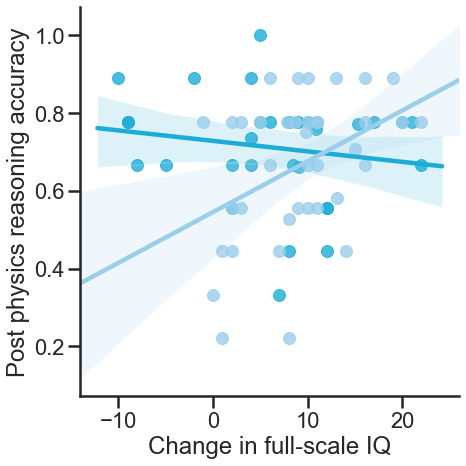

In [84]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaFSIQ', 'FCIPhyAcc2', data=df_m, hue='Mod', 
           palette=m_2, legend=False, height=7., )
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in full-scale IQ')
g.set_ylabels('Post physics reasoning accuracy')
g.savefig(join(fig_dir, 'delta_fsiqXpost_fci_acc-m_imp.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

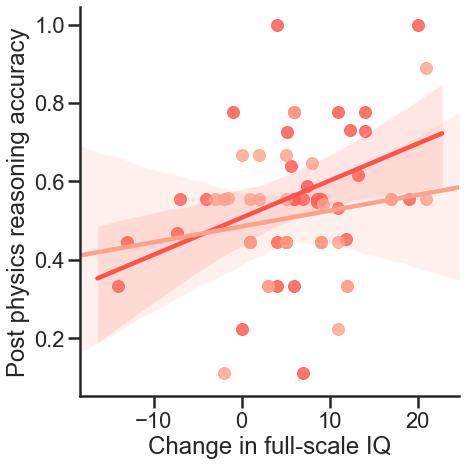

In [85]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaFSIQ', 'FCIPhyAcc2', data=df_f, hue='Mod', 
           palette=f_2, legend=False, height=7.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in full-scale IQ')
g.set_ylabels('Post physics reasoning accuracy')
g.savefig(join(fig_dir, 'delta_fsiqXpost_fci_acc-f_imp.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

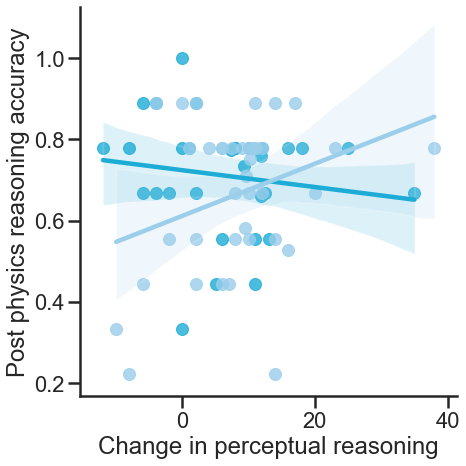

In [86]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaPRI', 'FCIPhyAcc2', data=df_m, hue='Mod', 
           palette=m_2, legend=False, height=7., truncate=True)
#g.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
g.set_xlabels('Change in perceptual reasoning')
g.set_ylabels('Post physics reasoning accuracy')
g.savefig(join(fig_dir, 'delta_priqXpost_fci_acc-m_imp.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

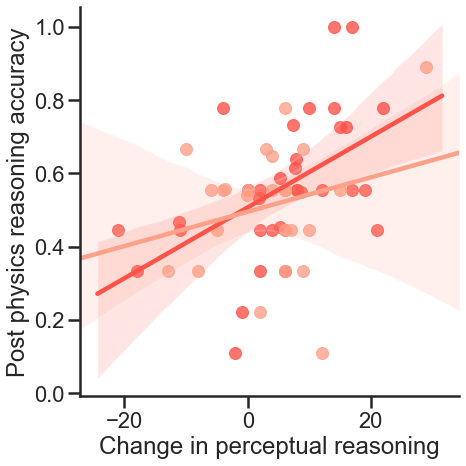

In [87]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaPRI', 'FCIPhyAcc2', data=df_f, hue='Mod', 
           palette=f_2, legend=False, height=7.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in perceptual reasoning')
g.set_ylabels('Post physics reasoning accuracy')
g.savefig(join(fig_dir, 'delta_priqXpost_fci_acc-f_imp.png'), dpi=300)

In [88]:
crayons_d = sns.crayon_palette(['Midnight Blue', 'Brick Red'])

<Figure size 432x288 with 0 Axes>

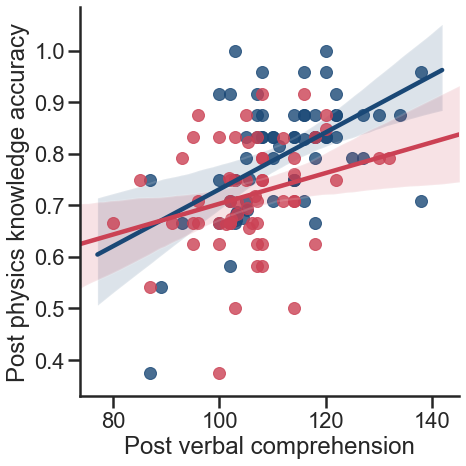

In [89]:
plt.tight_layout(pad=5)
g = sns.lmplot('VCI2', 'RetrPhyAcc2', data=all_df, hue='F', 
           palette=crayons_d, legend=False, height=7.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Post verbal comprehension')
g.set_ylabels('Post physics knowledge accuracy')
g.savefig(join(fig_dir, 'vci2Xpost_retr_acc-imp.png'), dpi=300)

<Figure size 432x288 with 0 Axes>

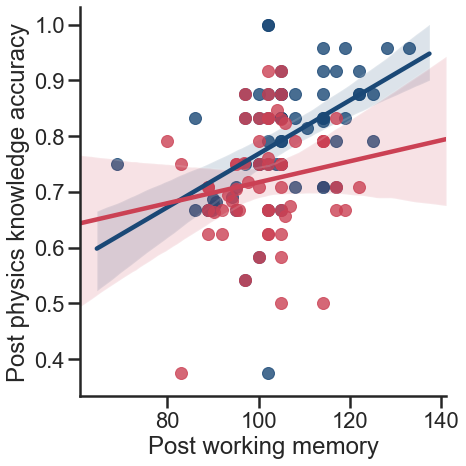

In [90]:
plt.tight_layout(pad=5)
g = sns.lmplot('WMI2', 'RetrPhyAcc2', data=all_df, hue='F', 
           palette=crayons_d, legend=False, height=7.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])

g.set_xlabels('Post working memory')
g.set_ylabels('Post physics knowledge accuracy')
g.savefig(join(fig_dir, 'wmi2Xpost_retr_acc-imp.png'), dpi=300)

## Gender Identity?

In [91]:

index = pd.MultiIndex.from_product((sessions, ivs))
sig = []
sig_mod = []
out_df = pd.DataFrame(index=index)
for session in sessions:
        for iv in ivs:
            if session == 'pre':
                variables = ['{0}1'.format(iv)]
                y = data['GID Pre']
            if session == 'post':
                variables = ['{0}2'.format(iv)]
                y = data['GID Post']
            if session == 'delta':
                variables = ['delta{0}'.format(iv)]
                y = data['GID Post']
            for var in variables:
                exes = [var]
                if mods:
                    for mod in mods:
                        data['{0}X{1}'.format(var, mod)] = data[var] * data[mod]
                        exes.append('{0}X{1}'.format(var, mod))
            
                x = data[exes + covariates]
                x = sm.add_constant(x)
                reg1 = sm.OLS(endog=y, 
                              exog=x, 
                              missing='drop')
                brain_on_iq = reg1.fit()
                out_df.at[(session, iv), 'F-statistic'] = brain_on_iq.fvalue
                out_df.at[(session, iv), 'Prob (F-statistic)'] = brain_on_iq.f_pvalue
                out_df.at[(session, iv), 'AIC'] = brain_on_iq.aic
                out_df.at[(session, iv), 'BIC'] = brain_on_iq.bic
                for ex in exes:
                    out_df.at[(session, iv), '{0}_pval'.format(ex)] = brain_on_iq.pvalues['{0}'.format(ex)]
                    out_df.at[(session, iv), '{0}_beta'.format(ex)] = brain_on_iq.params['{0}'.format(ex)]
                if brain_on_iq.f_pvalue < mc_alpha and brain_on_iq.pvalues['{0}'.format(var)] < 0.05:
                    print(brain_on_iq.summary())
                    #print(var, session, task, condition, measure, parcellation)
                    sig_mod.append(brain_on_iq)
                    sig.append('{0} {1}'.format(iv, session))


NameError: name 'ivs' is not defined

In [ ]:
ttest_rel(all_df['GID Post'], all_df['GID Pre'])

In [ ]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaPRI', 'GID Post', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in PRI')
g.set_ylabels('Post-instruction recalled gender identity')
g.savefig(join(fig_dir, 'delta_priqXpost_gid-f_imp.png'), dpi=300)

In [ ]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaPRI', 'GID Post', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in PRI')
g.set_ylabels('Post-instruction recalled gender identity')
g.savefig(join(fig_dir, 'delta_priqXpost_gid-m_imp.png'), dpi=300)

In [ ]:
pearsonr(all_df['GID Post'], all_df['F'])

In [ ]:
from scipy.stats import pointbiserialr
pointbiserialr(all_df['GID Post'], all_df['F'])